In [1]:
%cd ..

/Users/treycole/Codes/WanPy


Fourier transform Bloch Hamiltonian to real space throughout BZ. Fourier transform again at any $k$ point you want to get interpolated bands

In [2]:
from WanPy.pythtb_Wannier import *
import WanPy.models as models
import WanPy.plotting as plot

from pythtb import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import sympy as sp 
import scipy

In [3]:
delta = 1
t0 = 0.1
tprime = 0.5

model = models.chessboard(t0, tprime, delta).make_supercell([[2,0], [0,2]])

orbs = model.get_orb()
n_orb = model.get_num_orbitals()
n_occ = int(n_orb/2)
lat_vecs = model.get_lat() # lattice vectors

low_E_sites = np.arange(0, model.get_num_orbitals(), 2)
high_E_sites = np.arange(1, model.get_num_orbitals(), 2)

In [21]:
u_wfs_full = wf_array(model, [20, 20])
u_wfs_full.solve_on_grid([0, 0])
chern = u_wfs_full.berry_flux([i for i in range(n_occ)])/(2*np.pi)

print(f"Chern number: {chern:.2f}")

Chern number: -0.00


In [14]:
# 2D k-mesh
nkx = 10
nky = 10
Nk = nkx*nky

k_mesh = gen_k_mesh(nkx, nky, flat=False, endpoint=False)
k_mesh_flat = gen_k_mesh(nkx, nky, flat=True, endpoint=False)

In [15]:
u_wfs_Wan = wf_array(model, [nkx, nky])

for i in range(k_mesh.shape[0]):
    for j in range(k_mesh.shape[1]):
        u_wfs_Wan.solve_on_one_point(k_mesh[i,j], [i,j])

In [16]:
omit_sites = 4
tf_list = list(np.setdiff1d(low_E_sites, [omit_sites])) # delta on lower energy sites omitting the last site

In [17]:
nk = 101
k_path = [[0.0, 0.0], [0.0, 0.5], [0.5, 0.5], [0.0, 0.0]]
(k_vec, k_dist, k_node) = model.k_path(k_path, nk, report=False)

evals, u_path = model.solve_all(k_vec, eig_vectors=True)
u_path = np.transpose(u_path, axes=(1,0,2)) # [*nk, n, orb]
psi_path = get_bloch_wfs(model, u_path, k_vec)
psi_tilde_int = get_psi_tilde(psi_path, tf_list)
u_tilde_int = get_bloch_wfs(model, psi_tilde_int, k_vec, inverse=True)

In [18]:
subspace = u_tilde_int
eigvals_sub, evecs_sub = diag_h_in_subspace(model, subspace, k_vec, ret_evecs=True)

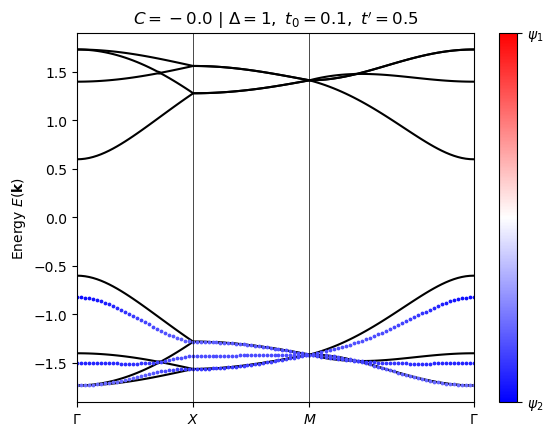

In [19]:
k_label = (r'$\Gamma $',r'$X$', r'$M$', r'$\Gamma $')
title = (rf"$C = {chern: .1f}$ | $\Delta = {delta},\ t_0 = {t0},\ t' = {tprime}$")
#  Interpolated bands
fig, ax = plot.plot_bands(
    model, k_path, evals=eigvals_sub, evecs=evecs_sub, k_label=k_label, sub_lat=True, red_lat_idx=high_E_sites, title=title)

# Original bands
for n in range(evals.shape[0]):
    ax.plot(k_dist, evals[n], c='k', lw=1.5, zorder=0)